# LiS Battery Model

We want to simulate the discharge of a Lithium Sulfur battery. The electrochemical equation for our system is 

$$ S_8^0 + 4e^- \to 2S_4^{2-} $$




In [2]:
%pylab inline
from pylab import *
from math import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
R = 8.3145     # gas constant [j/mole K]
T = 303.15     # Temperature of battery [K]
F = 96485.3321 # Faraday's constant [C/mole]
A = 0.9        # active surface area on electrode [m^2]
alpha = 0.5    # exchange coefficient [-]
n = 4          # stiochiometric coefficient of electrons [-] 
E0 = 2.4       # standard potential [V]
I0 = -.002     # standard current [A]
ms = 0.01      # mass of Sulfur in the battery [g] 
Ms = 32        # molar mass of elemental sulfur [moles/g]
n8 = 8         # number of elemental sulfur atoms in S_8^0 [-]
n4 = 4         # number of elemental sulfur atoms in S_4^{2-} [-]
V0 = 2.45      # standard voltage [V]

The following functions define the initial concentrations and the exchange current density as a function of electrolyte volume. 

In [4]:
def initial_conditions(nu):
    '''
    Defines the initial values for the concentration of both S_8^0 and S_4^{2-}
    
    Inputs
    ------
        nu: float, electrolyte volume
        
    Outputs
    -------
        C_S8_initial: float, initial concentration for S_8^0
        C_S4_initial: float, initial concentration for S_4^{2-}
    '''
    
    C_S8_initial = ms*0.99999/(Ms*n8*nu)
    C_S4_initial = ms*0.00001/(Ms*n4*nu)
    
    return C_S8_initial, C_S4_initial

def exchange_current_density(C_S8_initial, C_S4_initial, nu):
    '''
    Defines the exchange current density as a function of the initial concentrations
    and the electrolyte volume
    Inputs
    ------
        nu:           float, electrolyte volume
        C_S8_initial: float, initial concentration for S_8^0
        C_S4_initial: float, initial concentration for S_4^{2-}
        
    Outputs
    -------
        j0: float, exchange current density
    '''
    j0 = I0/(nu*A*(j_c(C_S4_initial,V0)-j_a(C_S8_initial,V0)))
    return j0

For the model, we will denote the concentration of $S_8^0$ as $C_{S8}$ and the concentration of $S_4^{2-}$ as $C_{S4}$. As the concentrations change, so too will the current output from the battery. We want to model how holding the battery at some voltage, $V$, will change the concentrations and the current. 

To begin, let us define a few functions. 

The anodic half-current is defined as the current density due to $S_8^0$ converting to $S_4^{-2}$ and is modelled via

$$ j_a(C_{S8},V) = n F C_{S8} e^{-\alpha \frac{n F (V-E_0)}{RT}} $$

The cathodic half-current is defined as the current density due to $S_4^{2-}$ converting to $S_8^{0}$ and is modelled via

$$ j_c(C_{S4},V) = n F \left(C_{S4}\right)^2 e^{(1-\alpha) \frac{n F (V-E_0)}{RT}} $$

In [5]:
def j_a(C_s8,V):
    '''
    Anodic half current, S8 to S4{2-}
    
    INPUTS
    C_s8: float, concentration of S8
    V: float, Voltage
    
    OUTPUT
    float, anodic half current
    '''
    output_coeff = n*F*C_s8
    output_exp = -1*alpha*n*F*(V-E0)/(R*T)
    
    return output_coeff * e**output_exp


def j_c(C_s4,V):
    '''
    Cathodic half current, S4{2-} to S8
    
    INPUTS
    C_s4: float, concentration of S4{2-}
    V: float, Voltage
    
    OUTPUT
    float, cathodic half current
    '''
    output_coeff = n*F* C_s4**2
    output_exp = (1-alpha)*n*F*(V-E0)/(R*T)
    
    return output_coeff * e**output_exp

The total current density for the reaction is defined as 

$$ j(C_{S8}, C_{S4}, V) = j_0 \big( j_c(C_{S4},V)-j_a(C_{S8},V) \big) $$ 

However, for our purposes, the constant $j_0$ is a function of electrolyte volume $\nu$. Since we will change the electrolyte volume many times, we will need to change $j_0$.

In [6]:
def j_(j0,C_s4,V,C_s8):
    '''
    Total current density, using both half current densities
    
    INPUTS:
    j0: float, 'constant' function of electrolyte volume
    C_s4: float, concentration of S4{2-}
    V: float, voltage
    C_s8: float, concentration of S8
    
    OUTPUT
    float, total current density
    '''
    return j0 * (j_c(C_s4,V)-j_a(C_s8,V))

The model for how the concentrations change through a discharge are given by the following ODEs:

$$ \frac{dC_{S8}}{dt} = \frac{A}{nF} j(C_{S8}, C_{S4}, V) $$
$$ \frac{dC_{S4}}{dt} = -2\frac{A}{nF} j(C_{S8}, C_{S4}, V) $$

The voltage $V$ is an input to the right hand sides of both equations, but will be set to a constant and so will not update with time. Treat V as an input parameter. Remember, we need to input the exchange current density constant, $j_0$, into the right hand side of both equations!

In [7]:
def dC_s8_dt(j0,C_s8,C_s4,V):
    '''
    Change in S8 concentration by time, calls total current density
    
    INPUTS:
    j0: float, 'constant' function of electrolyte volume
    C_s8: float, concentration of S8
    C_s4: float, concentration of S4{2-}
    V: float, voltage
    
    OUTPUT
    float, rate of change of S8 concentration
    '''
    return A/(n*F) * j_(j0,C_s4,V,C_s8)


def dC_s4_dt(j0,C_s4,C_s8,V):
    '''
    Change in S4{2-} concentration by time, calls total current density
    
    INPUTS:
    j0: float, 'constant' function of electrolyte volume
    C_s4: float, concentration of S4{2-}
    C_s8: float, concentration of S8
    V: float, voltage
    
    OUTPUT
    float, rate of change of S4{2-} concentration
    '''
    return -2*A/(n*F) * j_(j0,C_s4,V,C_s8)

In [8]:
def RK_step(f1,f2,C_sUP,C_sNUP,j0,V,dt):
    '''
    Runge Kutta step - 2nd order forward euler estimate of a forward value
    
    INPUTS
    f1: function, with updating concentration dependance for updating concentration
    f2: function, for forward concentration guess for non updating concentration
    C_sUP: float, concentration for update
    C_sNUP: float, concentration that is NOT updated
    j0: float, 'constant' function of electrolyte volume
    V: float, voltage
    dt: float, forward estimate time step
    
    OUTPUT
    C_sUP_NEW: float, forward estimate/update of concentration
    '''
    C_sUP_NEW = C_sUP + dt*f1(j0,C_sUP + 0.5*dt*f1(j0,C_sUP,C_sNUP,V),C_sNUP + 0.5*dt*f2(j0,C_sNUP,C_sUP,V),V)
    
    return C_sUP_NEW
   
    
def RK(V,time_step,vol):
    '''
    Runge Kutta method, using previously defined RK_step and for the rate of changes of concentrations
    
    INPUTS
    V: float, voltage
    time_step: float, 'dt' forward estimate time step
    vol: float, electrolyte volume
    
    OUTPUTS
    t_list: list, progression of times for each RK step
    C_s8_list: list, progression of S8 concentration estimates using RK_step
    C_s4_list: list, progression of S4{2-} concentration estimates using RK_step
    '''
    
    time_units = 2000
    dt = time_step
    
    C_s8_list = [initial_conditions(vol)[0]]
    C_s4_list = [initial_conditions(vol)[1]]
    j0 = exchange_current_density(initial_conditions(vol)[0],initial_conditions(vol)[1],vol)
    t_list = [0]
    
    for i in range(1,int(time_units/time_step)+1):
        t = dt * i
        C_s8_NEW = RK_step(dC_s8_dt,dC_s4_dt,C_s8_list[-1],C_s4_list[-1],j0,V,dt)
        C_s4_NEW = RK_step(dC_s4_dt,dC_s8_dt,C_s4_list[-1],C_s8_list[-1],j0,V,dt)
        
        t_list.append(t)
        C_s8_list.append(C_s8_NEW)
        C_s4_list.append(C_s4_NEW)
 
    return t_list, C_s8_list, C_s4_list

To check the model is consistent with our expectations, we can first run the model at the equilibrium voltage. We should see little to no change in the numerical values of the simulation at these conditions. 

The equilibrium voltage is defined by the Nernst potential, 

$$ V_{equilibrium} = E_0 + \frac{RT}{nF}\ln\left( \frac{C_{S8}}{(C_{S4})^2}\right)$$


In [9]:
C_s8_initial = initial_conditions(0.001)[0]
C_s4_initial = initial_conditions(0.001)[1]

V_eq = E0 + R*T/(n*F) * log(C_s8_initial/(C_s4_initial**2))
print(C_s8_initial,C_s4_initial,V_eq)

0.039062109375 7.8125e-07 2.562502532417324


Equillibrium voltage is 2.562502532417324

In [10]:
# equillibrium voltage - start voltage when not connected
t_list = RK(V=2.56,time_step=1,vol=0.001)[0]
C_s8_array = array(RK(V=2.562502532417324,time_step=1,vol=0.001)[1])
C_s4_array = array(RK(V=2.562502532417324,time_step=1,vol=0.001)[2])

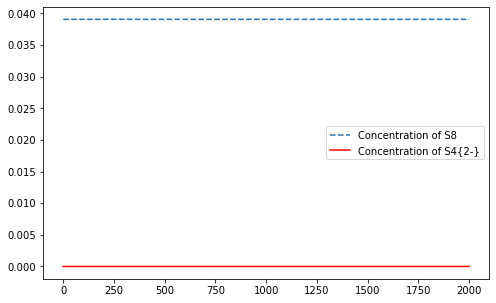

In [11]:
figure(figsize=[8,5])
plot(t_list,C_s8_array,linestyle='--',marker='',label='Concentration of S8')
plot(t_list,C_s4_array,linestyle='-',marker='',color='red',label='Concentration of S4{2-}')
legend(loc='center right')
show()

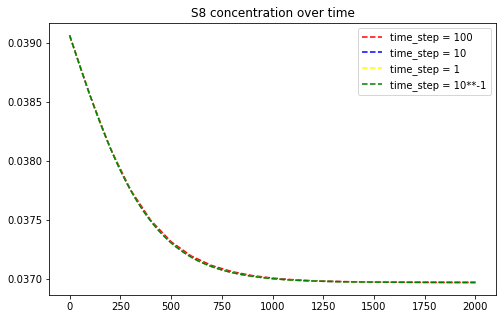

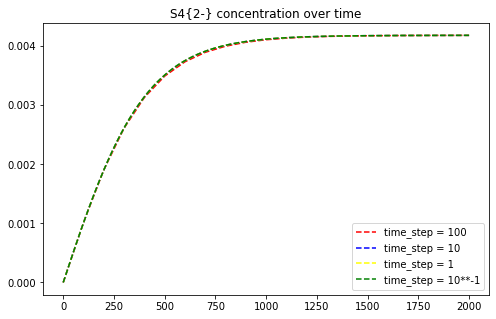

In [12]:
t_list_100 = RK(V=2.45,time_step=100,vol=0.001)[0]
problem_5_list_C_s8_100 = RK(V=2.45,time_step=100,vol=0.001)[1]
problem_5_list_C_s4_100 = RK(V=2.45,time_step=100,vol=0.001)[2]

t_list_10 = RK(V=2.45,time_step=10,vol=0.001)[0]
problem_5_list_C_s8_10 = RK(V=2.45,time_step=10,vol=0.001)[1]
problem_5_list_C_s4_10 = RK(V=2.45,time_step=10,vol=0.001)[2]

t_list_1 = RK(V=2.45,time_step=1,vol=0.001)[0]
problem_5_list_C_s8_1 = RK(V=2.45,time_step=1,vol=0.001)[1]
problem_5_list_C_s4_1 = RK(V=2.45,time_step=1,vol=0.001)[2]

t_list_e1 = RK(V=2.45,time_step=10**-1,vol=0.001)[0]
problem_5_list_C_s8_e1 = RK(V=2.45,time_step=10**-1,vol=0.001)[1]
problem_5_list_C_s4_e1 = RK(V=2.45,time_step=10**-1,vol=0.001)[2]

t_list_e2 = RK(V=2.45,time_step=10**-2,vol=0.001)[0]
problem_5_list_C_s8_e2 = RK(V=2.45,time_step=10**-2,vol=0.001)[1]
problem_5_list_C_s4_e2 = RK(V=2.45,time_step=10**-2,vol=0.001)[2]

figure(figsize = [8,5])
title('S8 concentration over time')
plot(t_list_100,problem_5_list_C_s8_100,marker='',linestyle='--',color='red',label='time_step = 100')
plot(t_list_10,problem_5_list_C_s8_10,marker='',linestyle='--',color='blue',label='time_step = 10')
plot(t_list_1,problem_5_list_C_s8_1,marker='',linestyle='--',color='yellow',label='time_step = 1')
plot(t_list_e1,problem_5_list_C_s8_e1,marker='',linestyle='--',color='green',label='time_step = 10**-1')
legend(loc='upper right')
show()

figure(figsize = [8,5])
title('S4{2-} concentration over time')
plot(t_list_100,problem_5_list_C_s4_100,marker='',linestyle='--',color='red',label='time_step = 100')
plot(t_list_10,problem_5_list_C_s4_10,marker='',linestyle='--',color='blue',label='time_step = 10')
plot(t_list_1,problem_5_list_C_s4_1,marker='',linestyle='--',color='yellow',label='time_step = 1')
plot(t_list_e1,problem_5_list_C_s4_e1,marker='',linestyle='--',color='green',label='time_step = 10**-1')
legend(loc='lower right')
show()

graph for dt = 0.1 is very close to dt = 1 sufficiently accurate (with graphs converging), while balancing computational time

The current output (in Amps) is defined by the function

$$ I = A \nu j(C_{S8},C_{S4},V)$$

In [13]:
def current(vol,C_s8,C_s4,V):
    '''
    Current for specific concentrations, electrolyte volume & voltage
    calls j0 using vol for j_
    
    INPUTS
    vol: float, electrolyte volume
    C_s8: float, concentration of S8
    C_s4: float, concentration of S4{2-}
    V: float, voltage
    
    OUTPUT
    float, current
    '''
    j0 = exchange_current_density(initial_conditions(vol)[0],initial_conditions(vol)[1],vol)
    
    return A * vol * j_(j0,C_s4,V,C_s8)


def current_array(V,time_step,vol):
    '''
    Delivers array of currents and time using Runge Kutta method for lists of concentrations and time 
    and the current function for floats elements in the array
    
    INPUTS
    V: float, voltage
    time_step: float, 'dt' forward estimate time step
    vol: float, electrolyte volume
    
    OUTPUTS
    t_list: list, progression of times for each RK step
    current_array: array, progression of current over change in concentrations
    '''
    t_list = RK(V,time_step, vol)[0]
    
    C_s8_list = RK(V,time_step,vol)[1]
    C_s4_list = RK(V,time_step,vol)[2]
    
    return t_list, current(vol,array(C_s8_list),array(C_s4_list),V)

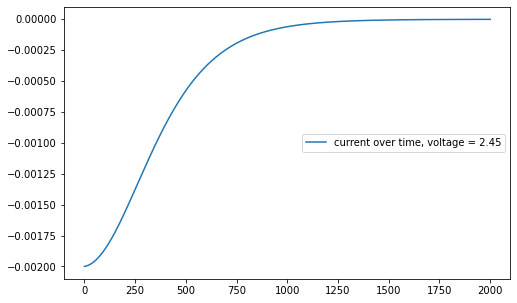

In [14]:
t_list = current_array(V=2.45,time_step = 10**-1, vol = 0.001)[0]
current_array1 = current_array(V=2.45,time_step = 10**-1, vol = 0.001)[1]

figure(figsize=[8,5])
plot(t_list, current_array1, linestyle='-',marker='',label='current over time, voltage = 2.45')
legend(loc='center right')
show()

In [15]:
t_list = current_array(V=2.45,time_step = 10**-1, vol = 0.001)[0]
current_array2 = current_array(V=2.4445,time_step = 10**-1, vol = 0.001)[1]
current_array3 = current_array(V=2.44,time_step = 10**-1, vol = 0.001)[1]
current_array4 = current_array(V=2.435,time_step = 10**-1, vol = 0.001)[1]
current_array5 = current_array(V=2.43,time_step = 10**-1, vol = 0.001)[1]

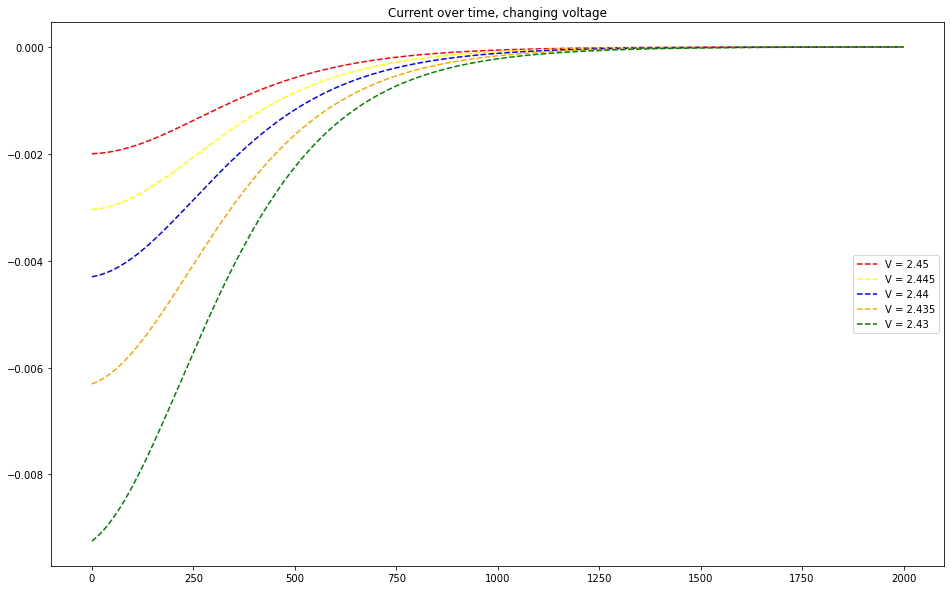

In [28]:
figure(figsize=[16,10])
plot(t_list,current_array1,marker='',linestyle='--',color='red',label='V = 2.45')
plot(t_list,current_array2,marker='',linestyle='--',color='yellow',label='V = 2.445')
plot(t_list,current_array3,marker='',linestyle='--',color='blue',label='V = 2.44')
plot(t_list,current_array4,marker='',linestyle='--',color='orange',label='V = 2.435')
plot(t_list,current_array5,marker='',linestyle='--',color='green',label='V = 2.43')
legend(loc='center right')
title('Current over time, changing voltage')
show()

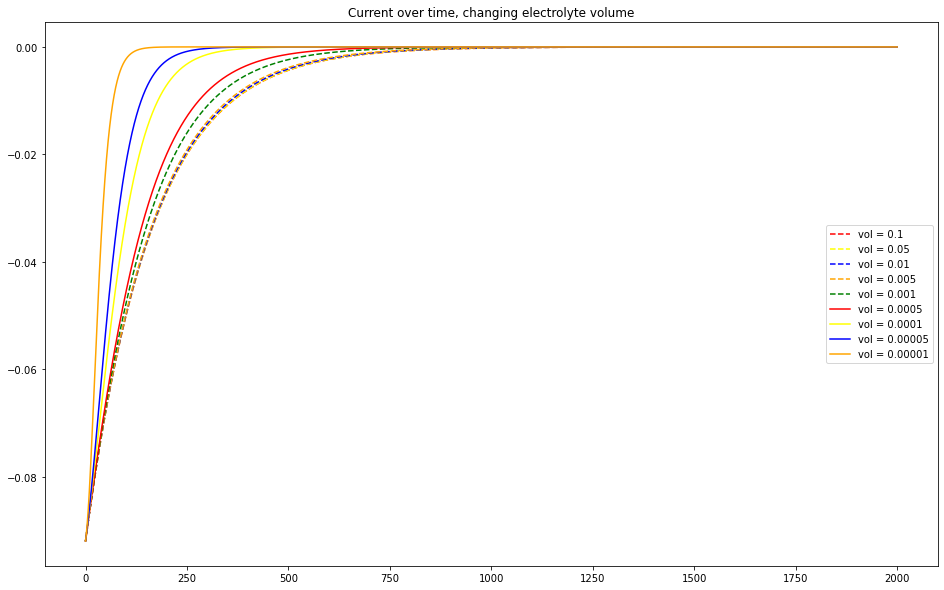

In [37]:
t_list = current_array(V=2.45,time_step = 10**-1, vol = 0.001)[0]
current_array6 = current_array(V=2.4,time_step = 10**-1, vol = 0.1)[1]
current_array7 = current_array(V=2.4,time_step = 10**-1, vol = 0.05)[1]
current_array8 = current_array(V=2.4,time_step = 10**-1, vol = 0.01)[1]
current_array9 = current_array(V=2.4,time_step = 10**-1, vol = 0.005)[1]
current_array10 = current_array(V=2.4,time_step = 10**-1, vol = 0.001)[1]
current_array11 = current_array(V=2.4,time_step = 10**-1, vol = 0.0005)[1]
current_array12 = current_array(V=2.4,time_step = 10**-1, vol = 0.0001)[1]
current_array13 = current_array(V=2.4,time_step = 10**-1, vol = 0.00005)[1]
current_array14 = current_array(V=2.4,time_step = 10**-1, vol = 0.00001)[1]

figure(figsize=[16,10])
plot(t_list,current_array6,marker='',linestyle='--',color='red',label='vol = 0.1')
plot(t_list,current_array7,marker='',linestyle='--',color='yellow',label='vol = 0.05')
plot(t_list,current_array8,marker='',linestyle='--',color='blue',label='vol = 0.01')
plot(t_list,current_array9,marker='',linestyle='--',color='orange',label='vol = 0.005')
plot(t_list,current_array10,marker='',linestyle='--',color='green',label='vol = 0.001')
plot(t_list,current_array11,marker='',linestyle='-',color='red',label='vol = 0.0005')
plot(t_list,current_array12,marker='',linestyle='-',color='yellow',label='vol = 0.0001')
plot(t_list,current_array13,marker='',linestyle='-',color='blue',label='vol = 0.00005')
plot(t_list,current_array14,marker='',linestyle='-',color='orange',label='vol = 0.00001')
legend(loc='center right')
title('Current over time, changing electrolyte volume')
show()

Suppose we are constructing a LiS battery and can change the electrolyte volume. We want to know the relationship between the discharge capacity for a constant voltage discharge and the electrolyte volume. 

The capacity (in Ah) is defined as: 

$$ \frac{-1}{3600}\int_{t=0}^{T_f} I(t) dt $$ 

where $T_f$ is the final time and $I(t)$ is the current from the battery.  

In [18]:
def Trapezoid(f,V,vol,time_step):
    '''
    Trapezoid approximation of an integral from time zero to final time of 2000 units
    alpha for weighting of LHS vs RHS subsection height
    
    INPUTS
    f: function within integral, current_array for our purposes
    V: float, starting voltage
    vol: float, electrolyte volume
    time_step: float, for forward estimate in runge kutta and subsection base length
    
    OUTPUT
    float, constant multiplied by approximation of integral
    '''
    
    f_approx = f(V,time_step,vol)
    integral_approx = (0.5*f_approx[1][0] + sum(f_approx[1][1:-1]) + 0.5*f_approx[1][-1])*time_step
    
    return -1/3600 * integral_approx

In [19]:
discharge_capacity1 = Trapezoid(current_array,V=2.4,vol=0.1,time_step=0.1)
print('dischange capacity for vol = 0.1',discharge_capacity1)

dischange capacity for vol = 0.1 0.0041811466339675245


In [20]:
vol_list9 = [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]

for i in vol_list9:
    print('discharge capacity for v =',i,Trapezoid(current_array,V=2.4,vol = i,time_step=0.1))

discharge capacity for v = 0.1 0.0041811466339675245
discharge capacity for v = 0.05 0.0041746648512115325
discharge capacity for v = 0.01 0.004124210377848114
discharge capacity for v = 0.005 0.004064404566887432
discharge capacity for v = 0.001 0.0036818766557947307
discharge capacity for v = 0.0005 0.0033501436609153154
discharge capacity for v = 0.0001 0.0022681444706345176
discharge capacity for v = 5e-05 0.0017917950370021619
discharge capacity for v = 1e-05 0.0009338152662008857


It would appear that we should just increase the electroyte volume to get the most capacity out of the cell. Although this is true, it comes at a cost (literally). The cost per capacity (labelled CPC and in units £/Ah) can be written as function of electrolyte in the following way: 

$$ CPC = \frac{1+\nu^2}{capacity}$$

In [21]:
def CPC(vol,V,time_step):
    '''
    Cost per Capacity of Lithium Sulphide cell for a specific volume,
    using trapezoid integral approximation of current_array function
    
    INPUTS:
    vol: float, electrolyte volume
    V: float, initial voltage
    time_step: float, change in time for forward runge kutta estimate and trapezoid base subsection length
    
    OUTPUT
    float, cost per cell capacity
    '''
    return (1+vol**2)/Trapezoid(current_array,V,vol,time_step)

CPC for vol = 0.1 is 241.56053073929212
CPC for vol = 0.09 is 241.14776192662382
CPC for vol = 0.08 is 240.79306170689105
CPC for vol = 0.07 is 240.50083860637534
CPC for vol = 0.06 is 240.2784326202063
CPC for vol = 0.05 is 240.1390376784531
CPC for vol = 0.04 is 240.10899106038534
CPC for vol = 0.03 is 240.24956771764258
CPC for vol = 0.02 is 240.74366447278405
CPC for vol = 0.01 is 242.4949040843599


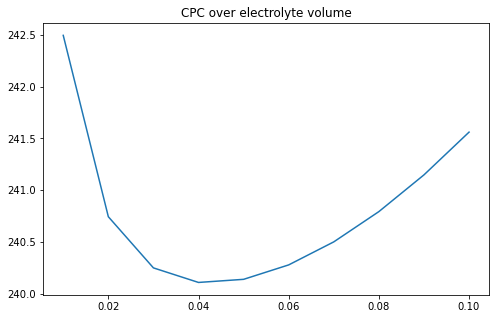

In [22]:
vol_list = [0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
CPC_list = []
for i in vol_list:
    CPC_list.append(CPC(vol=i,V=2.4,time_step=0.1))
    print('CPC for vol =',i,'is',CPC_list[-1])
    
figure(figsize=[8,5])
plot(vol_list,CPC_list,marker='')
title('CPC over electrolyte volume')
show()

Since we want to optimize the value of CPC by finding the optimal electrolyte volume, we should use the optimisation algorithm gradient descent. However, that method requires that we differentiate the CPC. We cannot do that with pen and paper. So we must numerically differentiate the function with respect to electrolyte volume. However, we need to be careful of the choice of step size in electrolyte volume of the numerical derivative. Too small a step size and we will encounter rounding errors. Too large a step size and the derivative value will be to inaccurate. 


We should observe that for the middle values of numerical derivative step size the derivative values are fairly consistent. We should also notice that most of the simulation time steps yield similar results. However, $dt=10$ is certainly inconsistent with the others. Moreover, $10^{-2}$ takes a rather long time to run. Therefore, we will continue using the simulation step size of $10^{-1}$.

In [23]:
def d_CPC_dvol(V,vol,time_step,step_size):
    '''
    Derivative of CPC using the formula for first derivative over a small step size
    
    INPUTS
    V: float, tarting voltage
    vol: float, electrolyte volume
    time_step: float, time step size for runge kutta method
    step_size: float, small change in volume value for numerical derivative from first principles
    
    OUTPUT
    CPC_deriv: float, CPC gradient at a particular voltage & electrolyte volume
    '''
    CPC_deriv = (CPC(vol+step_size,V,time_step)-CPC(vol,V,time_step))/step_size
    return CPC_deriv

CPC derivative for step size = 10 is 2407.011916261322
CPC derivative for step size = 1 is 257.0441401601586
CPC derivative for step size = 0.1 is 36.39166926272168
CPC derivative for step size = 0.01 is 3.0046618067757436
__
CPC derivative for step size = 0.0001 is -3.9152180426071936
CPC derivative for step size = 1e-05 is -3.9884275793156116
CPC derivative for step size = 1e-05 is -3.9884275793156116
CPC derivative for step size = 1e-07 is -3.996493092017772
CPC derivative for step size = 1e-08 is -3.996566988462291
CPC derivative for step size = 1e-09 is -3.996092345914803
CPC derivative for step size = 1e-10 is -3.9977976484806277
CPC derivative for step size = 1e-11 is -3.9506176108261575


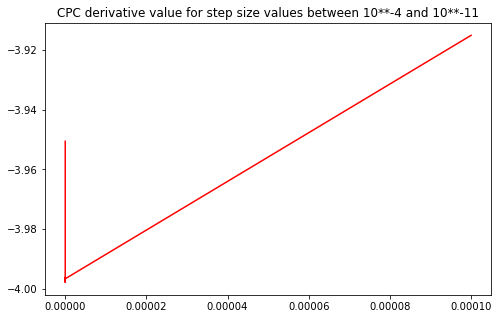

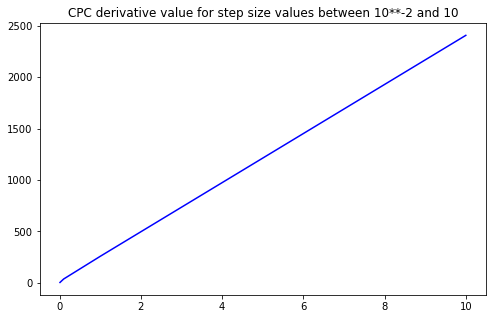

In [24]:
step_size_list1 = [10**-4,10**-5,10**-5,10**-7,10**-8,10**-9,10**-10,10**-11]
step_size_list2 = [10,1,10**-1,10**-2]

d_CPC_dvol_list1 = []
d_CPC_dvol_list2 = []

for i in step_size_list2:
    d_CPC_dvol_list2.append(d_CPC_dvol(V=2.4,vol=0.04,time_step=0.1,step_size=i))
    print('CPC derivative for step size =',i,'is',d_CPC_dvol_list2[-1])
    if i == step_size_list2[-1]:
        print('__')

for i in step_size_list1:
    d_CPC_dvol_list1.append(d_CPC_dvol(V=2.4,vol=0.04,time_step=0.1,step_size=i))
    print('CPC derivative for step size =',i,'is',d_CPC_dvol_list1[-1])
    
figure(figsize=[8,5])
plot(step_size_list1,d_CPC_dvol_list1,marker='',color='red')
title('CPC derivative value for step size values between 10**-4 and 10**-11')
show()

figure(figsize=[8,5])
plot(step_size_list2,d_CPC_dvol_list2,marker='',color='blue')
title('CPC derivative value for step size values between 10**-2 and 10')
show()


In [25]:
def GD_step(dfdx, vol_old, lamb, V,time_step,step_size):
    '''
    Each gradient descent step
    
    INPUTS
    dfdx: function, gradient for step 
    vol_old: float, electrolyte volume for use in function for gradient
    lamb: float, step size coefficient
    V: float, voltage
    time_step: float, change in time for forward runge kutta estimate and trapezoid base subsection length (for capacity)
    step_size: float, small change in volume value for numerical derivative from first principles
    
    OUTPUT
    float, new volume down gradient descent 
    '''
    return vol_old - lamb*dfdx(V,vol_old,time_step,step_size)


def GD_method(dfdx,lamb, V,time_step,step_size):
    '''
    Gradient descent method, building a list of new volumes from & to be used for next gradient descent step
    
    INPUTS
    dfdx: function, gradient for step 
    lamb: float, step size coefficient
    V: float, voltage
    time_step: float, change in time for forward runge kutta estimate and trapezoid base subsection length (for capacity)
    step_size: float, small change in volume value for numerical derivative from first principles
    
    OUTPUT
    vol_array: list, new volumes down gradient descent until gradient is sufficiently close to zero
    '''
    tol = 10**-4
    vol_array = [0.01] # first element inital volume guess
    
    while abs(dfdx(V,vol_array[-1],time_step,step_size)) > tol:
        vol_array.append(GD_step(dfdx, vol_array[-1], lamb, V , time_step , step_size))
                       
    return vol_array

Best lamb seen to be 0.0007, giving final value for minimum CPC at vol = 0.0426

In [26]:
GD_method(d_CPC_dvol,lamb=0.0007,V=2.4,time_step=0.1,step_size=10**-6)

[0.01,
 0.2599717962990644,
 0.17341901699661322,
 0.11628298338701826,
 0.07930776348781365,
 0.056903514746077244,
 0.0458748233793449,
 0.042837436566524056,
 0.042618598476119596,
 0.04261786104076237]

Not particularly nescesary but interesting to see best lambda ('lamb')

In [27]:
def GD_method_step_count(dfdx,lamb, V,time_step,step_size, max_steps):
    '''
    Gradient descent method, building a list of new volumes from & to be used for next gradient descent step
    Outputs the step number and aborts if over 18 (min step number found with lamb = 0.0005)
    
    INPUTS
    dfdx: function, gradient for step 
    lamb: float, step size coefficient
    V: float, voltage
    time_step: float, change in time for forward runge kutta estimate and trapezoid base subsection length (for capacity)
    step_size: float, small change in volume value for numerical derivative from first principles
    max_steps: float, the maximum number of steps allowed before the lamb value is poorer than another 
    
    OUTPUT
    vol_array: list, new volumes down gradient descent until gradient is sufficiently close to zero
    '''
    tol = 10**-4
    vol_array = [0.01] # first element inital volume guess
    
    while abs(dfdx(V,vol_array[-1],time_step,step_size)) > tol:
        vol_array.append(GD_step(dfdx, vol_array[-1], lamb, V , time_step , step_size))
        print('step',len(vol_array)-1)
        if len(vol_array) > max_steps:
            return 'TOO SLOW!', vol_array
                       
    return vol_array

In [29]:
GD_method_step_count(d_CPC_dvol,lamb=0.001,V=2.4,time_step=0.1,step_size=10**-6,max_steps=18)

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17


[0.01,
 0.3671025661415206,
 0.19201612007828772,
 0.10128330401608765,
 0.056499247360998206,
 0.04110116762172766,
 0.04335239654234102,
 0.042318858785629354,
 0.0427497726573256,
 0.04256157827991047,
 0.042642230792134805,
 0.042607377619342524,
 0.04262238561774212,
 0.04261591297132328,
 0.04261870210735652,
 0.042617499329035136,
 0.04261801847997959,
 0.042617794744282955]

In [31]:
lamb_test_list = [0.00095,0.0009,0.00085,0.0008,0.00075,0.0007,0.00065,0.0006,0.00055,0.0005,0.00045,0.0004,0.00035,0.0003,0.00025,0.0002,0.0001]
GD_method_step_test_list = []
for i in lamb_test_list:
    print('')
    print('lamb for gradient descent method', i)
    GD_method_step_test_list.append(len(GD_method_step_count(d_CPC_dvol,lamb=0.001,V=2.4,time_step=0.1,step_size=10**-6,max_steps=18)[1:]))


lamb for gradient descent method 0.00095
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17

lamb for gradient descent method 0.0009
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17

lamb for gradient descent method 0.00085
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17

lamb for gradient descent method 0.0008
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17

lamb for gradient descent method 0.00075
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17

lamb for gradient descent method 0.0007
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 

In [32]:
GD_method_step_test_list

[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]

In [36]:
[lamb_test_list] + [GD_method_step_test_list]
for i in range(len(lamb_test_list)-1):
    best = lamb_test_list[0]
    if GD_method_step_test_list[i+1] < best:
        best = lamb_test_list[i+1]
best

0.00095